<a href="https://colab.research.google.com/github/mjojic/Portfolio/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 128

def load_transformed_dataset():
  data_transforms = [
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
  ]
  data_transform = transforms.Compose(data_transforms)

  # train = torchvision.datasets.CIFAR10(root=".", train = True, download=True, transform=data_transform)
  # test = torchvision.datasets.CIFAR10(root=".", train = False, download=True, transform=data_transform)

  train = torchvision.datasets.CelebA(root = "./content/drive", split = 'train', target_type = 'identity', transform = data_transform, download = True)
  test = torchvision.datasets.CelebA(root = "./content/drive", split = 'valid', target_type = 'identity', transform = data_transform, download = True)
  return torch.utils.data.ConcatDataset([train, test])

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=a4e1021f-265c-48b9-a03c-2558d56bca1b
To: /content/content/drive/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:32<00:00, 44.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/content/drive/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 176MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /content/content/drive/celeba/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 265MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /content/content/drive/celeba/list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:00<00:00, 215MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ
To

Files already downloaded and verified


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# input noise dimension
nz = 100
# number of generator filters
ngf = 64
# number of discriminator filters
ndf = 64
# number of input channels
nc = 3

In [ ]:
# Generator - Through convolution, produce synthetic images, train signal for backprop is the classification of the Discriminator
class Generator(nn.Module):
  def __init__(self, nc, ngf, nz):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
      nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
      nn.BatchNorm2d(ngf * 16),
      nn.ReLU(True),

      nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 8),
      nn.ReLU(True),

      nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 4),
      nn.ReLU(True),

      nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 2),
      nn.ReLU(True),

      nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf),
      nn.ReLU(True),

      nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
      nn.Tanh()
    )

  def forward(self, input):
    output = self.main(input)
    return output

# Discriminator - Compete with Generator, try to guess which data is real and fake, assigned labels are used to update loss of Generator
class Discriminator(nn.Module):
  def __init__(self, nc, ndf):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(

      nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 2),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 4),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 8),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 16),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    output = self.main(input)
    return output.view(-1, 1).squeeze(1)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)


In [ ]:
import random
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  1792


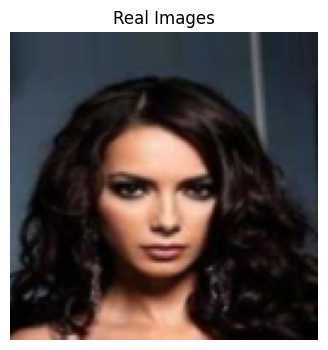

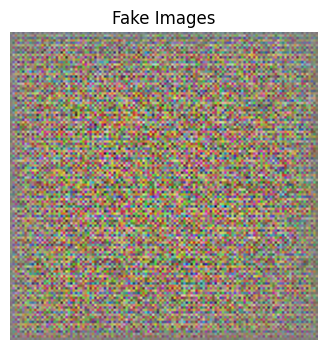

[0/25][0/1426] Loss_D: 1.1888 Loss_G: 11.6133 D(x): 0.5512 D(G(z)): 0.3694 / 0.0000


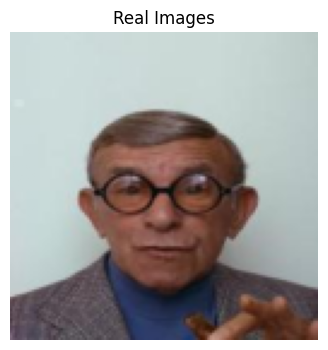

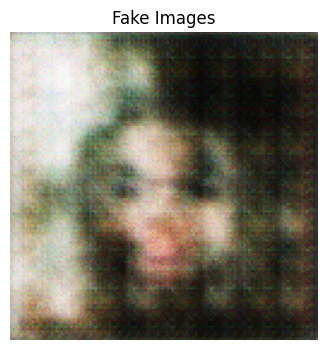

[0/25][500/1426] Loss_D: 1.2080 Loss_G: 1.6777 D(x): 0.4132 D(G(z)): 0.1652 / 0.1771


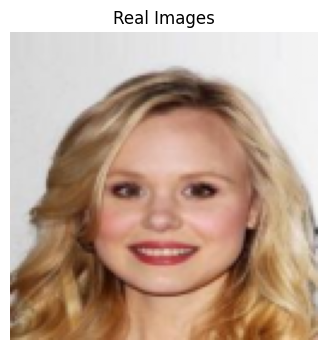

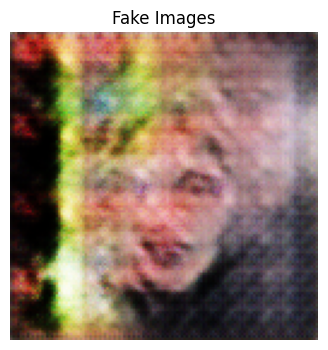

[0/25][1000/1426] Loss_D: 1.2469 Loss_G: 1.8572 D(x): 0.5193 D(G(z)): 0.3459 / 0.1559


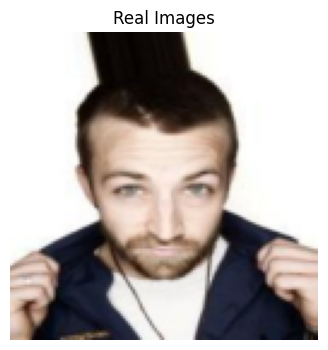

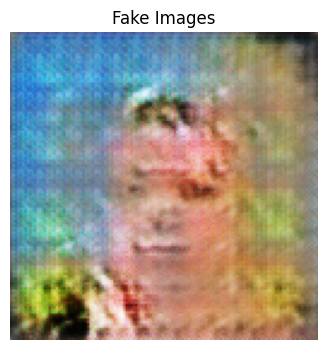

[0/25][1425/1426] Loss_D: 1.3238 Loss_G: 1.9402 D(x): 0.5834 D(G(z)): 0.4548 / 0.1729


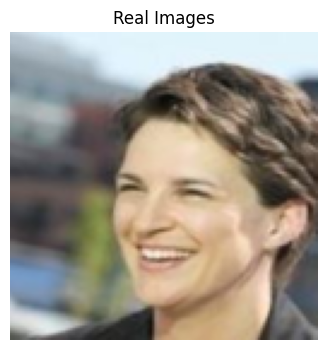

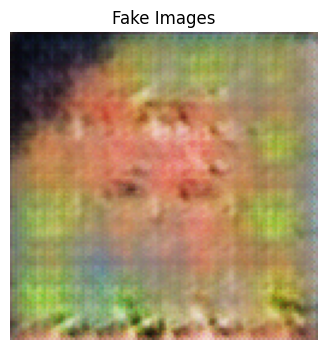

[1/25][0/1426] Loss_D: 1.4420 Loss_G: 1.6142 D(x): 0.4880 D(G(z)): 0.4162 / 0.1781


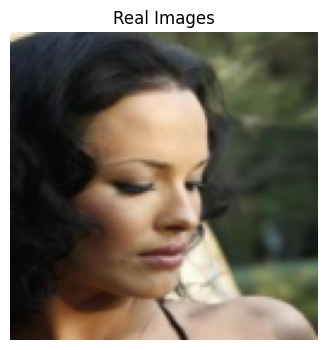

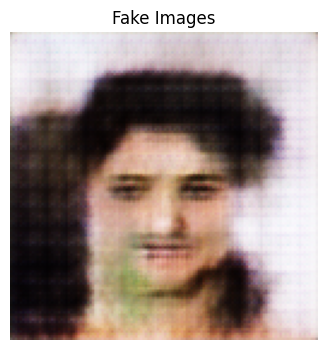

[1/25][500/1426] Loss_D: 1.2263 Loss_G: 1.7723 D(x): 0.5014 D(G(z)): 0.3600 / 0.1551


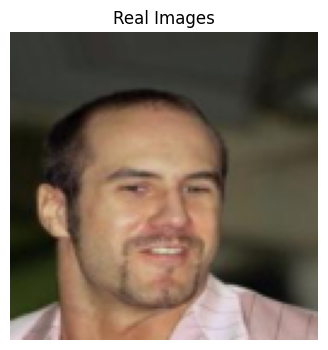

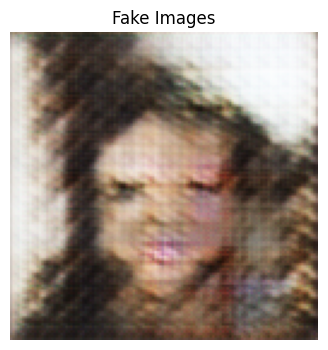

[1/25][1000/1426] Loss_D: 1.3989 Loss_G: 1.3342 D(x): 0.4302 D(G(z)): 0.4113 / 0.2800


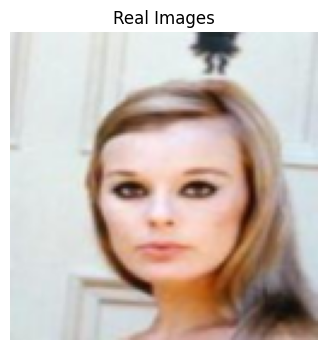

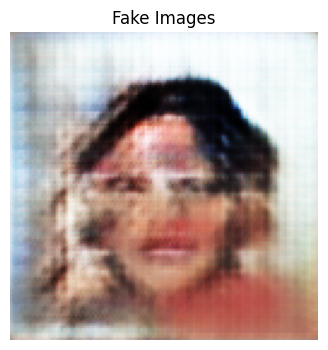

[1/25][1425/1426] Loss_D: 1.0980 Loss_G: 1.7157 D(x): 0.5436 D(G(z)): 0.3463 / 0.1582


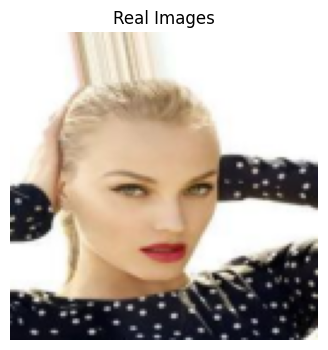

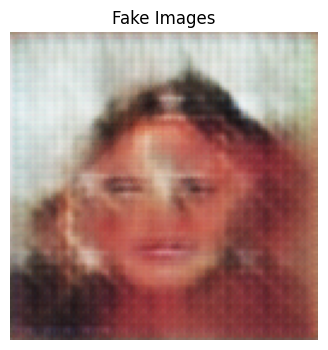

[2/25][0/1426] Loss_D: 1.0977 Loss_G: 1.9192 D(x): 0.6140 D(G(z)): 0.4052 / 0.1285


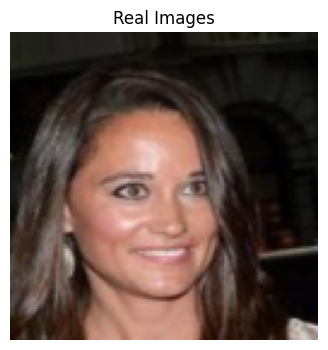

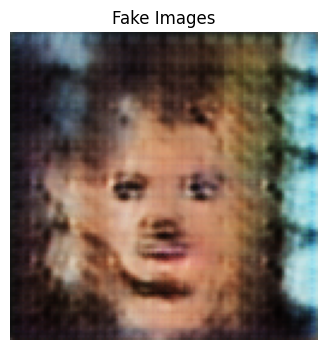

[2/25][500/1426] Loss_D: 1.2053 Loss_G: 1.6497 D(x): 0.5836 D(G(z)): 0.4554 / 0.1745


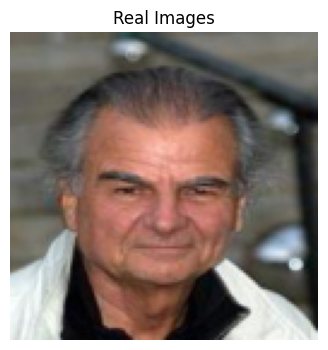

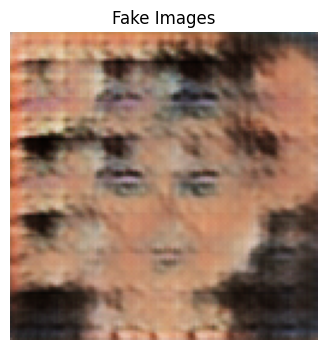

[2/25][1000/1426] Loss_D: 1.0439 Loss_G: 1.3680 D(x): 0.4548 D(G(z)): 0.1753 / 0.2405


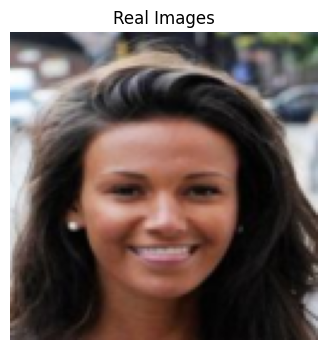

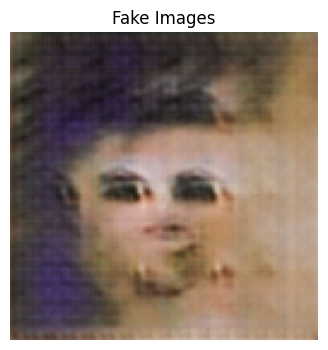

[2/25][1425/1426] Loss_D: 0.8813 Loss_G: 1.8108 D(x): 0.5046 D(G(z)): 0.1515 / 0.1560


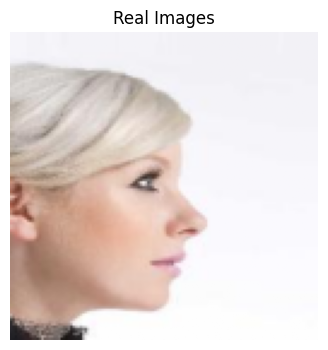

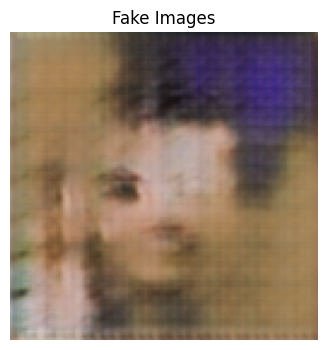

[3/25][0/1426] Loss_D: 0.9698 Loss_G: 2.7883 D(x): 0.8274 D(G(z)): 0.4440 / 0.0477


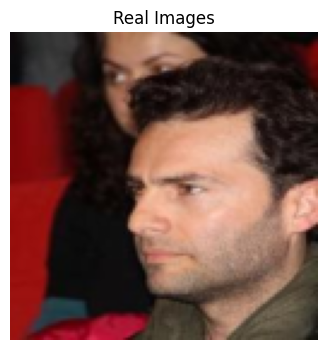

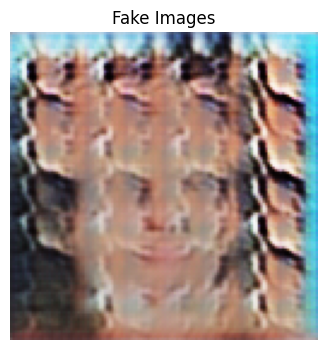

[3/25][500/1426] Loss_D: 1.0220 Loss_G: 2.4309 D(x): 0.6713 D(G(z)): 0.4073 / 0.0716


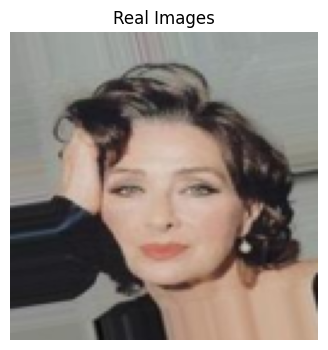

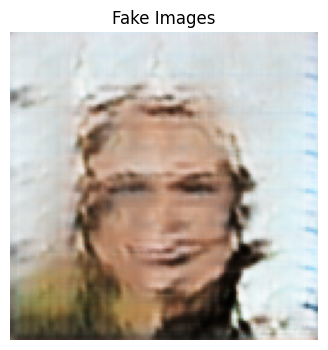

[3/25][1000/1426] Loss_D: 1.0093 Loss_G: 2.3811 D(x): 0.5668 D(G(z)): 0.3178 / 0.0734


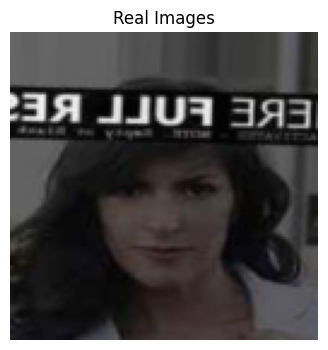

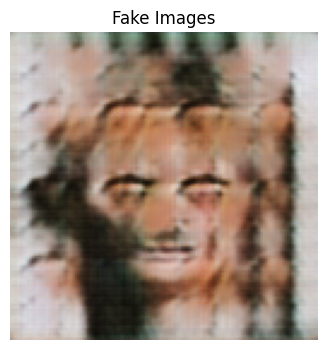

[3/25][1425/1426] Loss_D: 0.9627 Loss_G: 2.2247 D(x): 0.5783 D(G(z)): 0.3047 / 0.0873


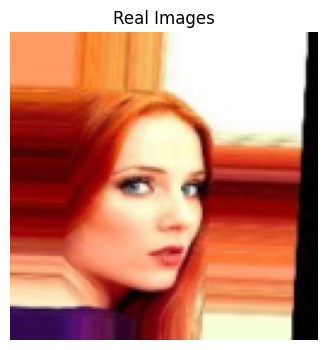

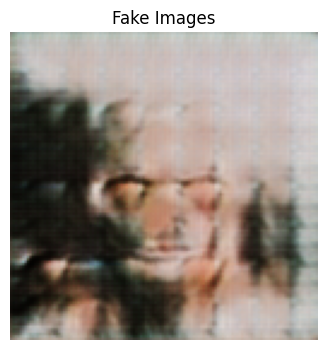

[4/25][0/1426] Loss_D: 0.8894 Loss_G: 2.0311 D(x): 0.6278 D(G(z)): 0.2911 / 0.1091


In [ ]:
import torch.optim as optim
# from torch.cuda.amp import GradScaler, autocast

netG = Generator(nc, ngf, nz).to(device)

netD = Discriminator(nc, ndf).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

# Setup loss function - Binary Cross Entropy Loss
criterion = nn.BCELoss()

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay = 0.1)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay = 0.1)

fixed_noise = torch.randn(128, nz, 1, 1, device=device)
real_label = 0.9
fake_label = 0

niter = 25
g_loss = []
d_loss = []

# scaler = GradScaler()

for epoch in range(niter):
  for i, data in enumerate(dataloader, 0):
    # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    # train with real
    netD.zero_grad()
    real_cpu = data[0].to(device)
    batch_size = real_cpu.size(0)
    label = torch.full((batch_size,), real_label, device=device)
    label = label.float()
    #label = label.view(-1, 1, 1, 1)

    # with autocast():
    output = netD(real_cpu)
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    # train with fake
    noise = torch.randn(batch_size, nz, 1, 1, device=device)
    fake = netG(noise)
    label.fill_(fake_label)

    # with autocast():
    output = netD(fake.detach())
    errD_fake = criterion(output, label)
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake

    optimizerD.step()

    # Update G network: maximize log(D(G(z)))
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost

    # with autocast():
    output = netD(fake)
    errG = criterion(output, label)
    errG.backward()
    D_G_z2 = output.mean().item()

    optimizerG.step()

    # scaler.step(optimizerD)
    # scaler.step(optimizerG)
    # scaler.update()


    #save the output
    if i % 500 == 0 or i == 1425:
      real_cpu_np = real_cpu.cpu().numpy().transpose(0, 2, 3, 1)
      fake_np = fake.detach().cpu().numpy().transpose(0, 2, 3, 1)

      # Shift and scale the images back to the range [0, 1]
      real_cpu_np = (real_cpu_np + 1) / 2.0
      fake_np = (fake_np + 1) / 2.0

      n = random.randint(0,99)

      # Display real images
      plt.figure(figsize=(4,4))
      plt.axis("off")
      plt.title("Real Images")
      plt.imshow(np.clip(real_cpu_np[n], 0, 1))
      plt.show()

      # Generate fake images
      fake = netG(fixed_noise)

      # Convert the tensor images to numpy arrays and transpose the dimensions
      fake_np = fake.detach().cpu().numpy().transpose(0, 2, 3, 1)

      # Shift and scale the images back to the range [0, 1]
      fake_np = (fake_np + 1) / 2.0

      # Display fake images
      plt.figure(figsize=(4,4))
      plt.axis("off")
      plt.title("Fake Images")
      plt.imshow(np.clip(fake_np[n], 0, 1))
      plt.show()

      print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, niter, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

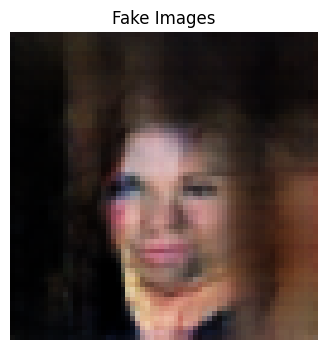

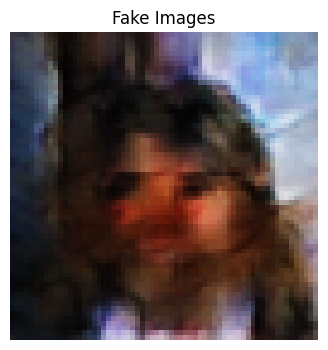

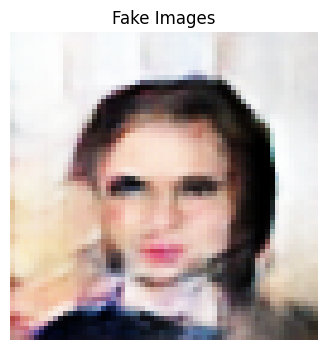

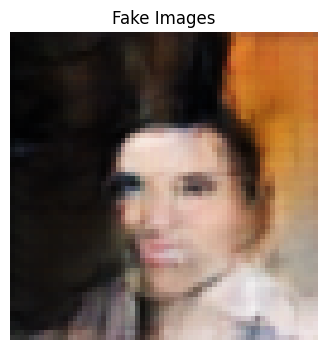

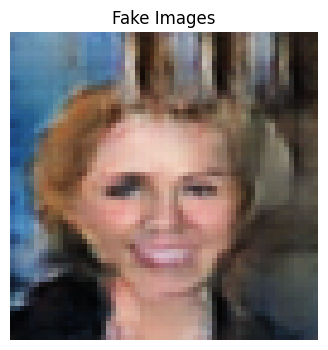

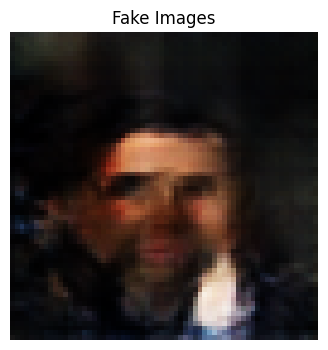

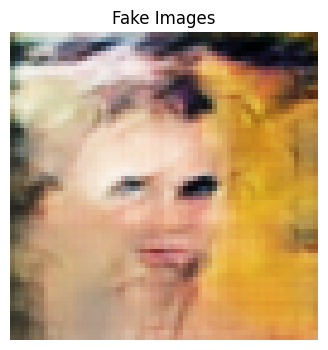

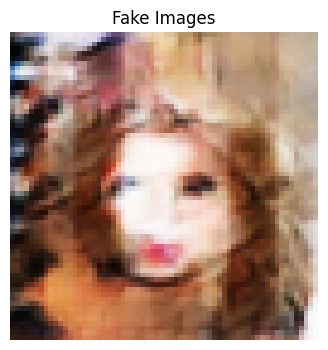

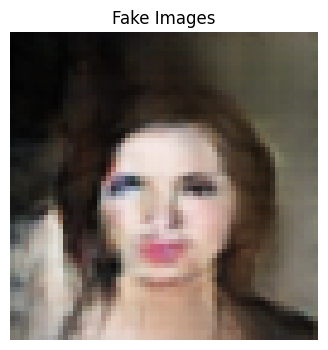

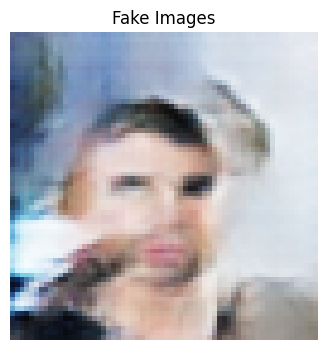

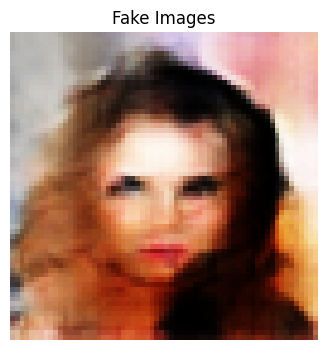

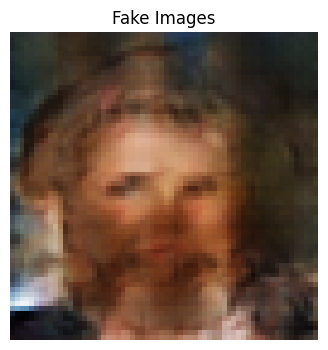

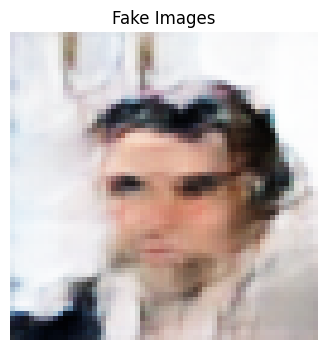

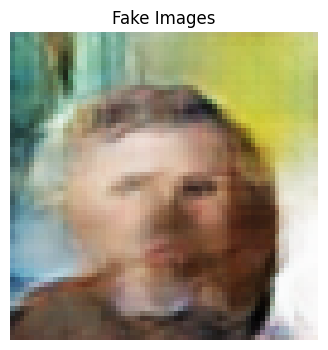

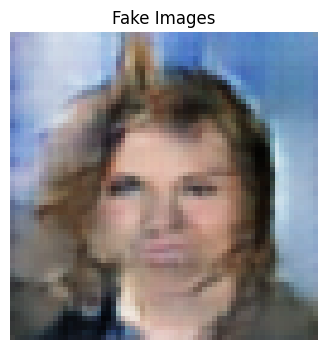

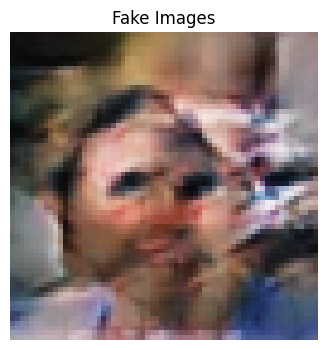

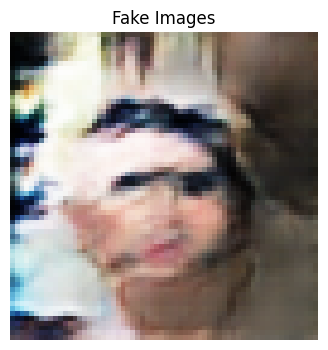

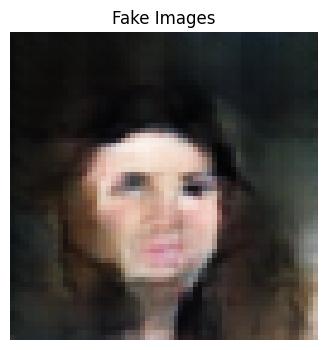

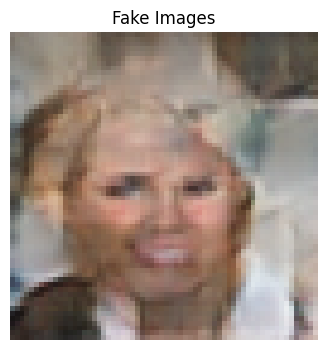

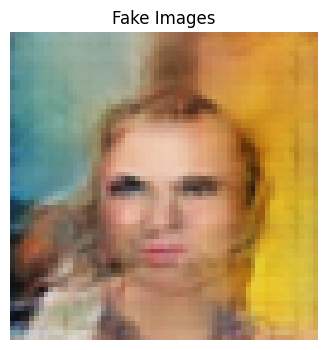

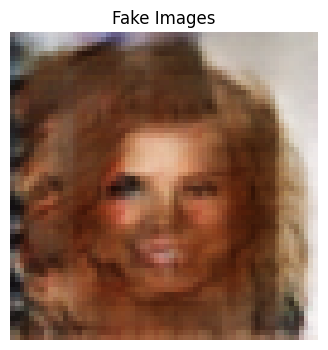

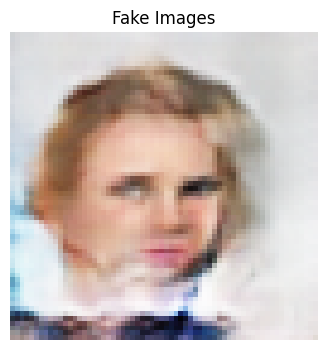

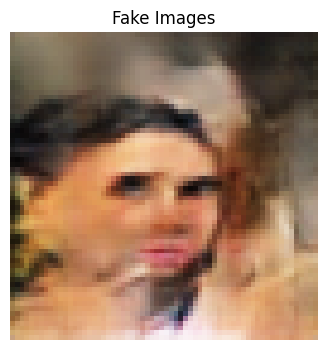

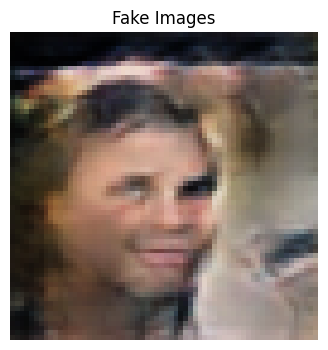

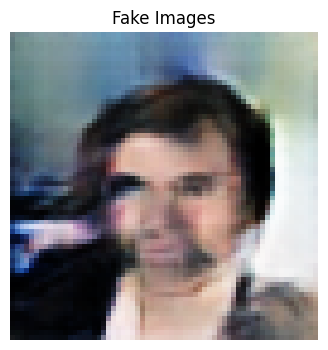

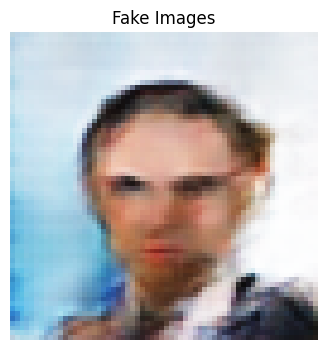

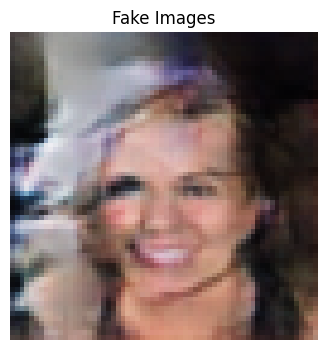

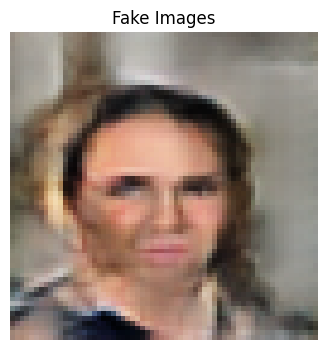

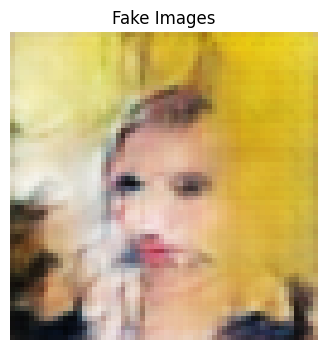

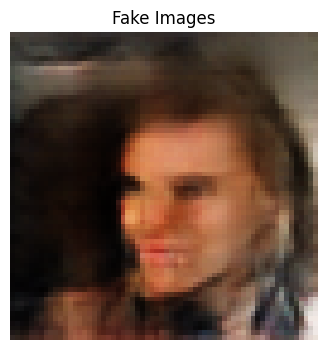

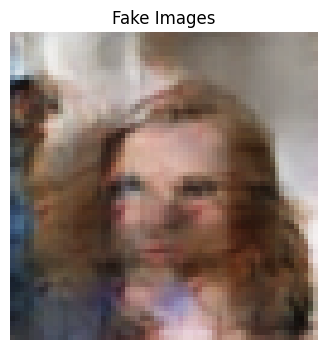

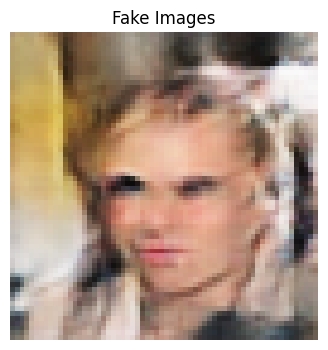

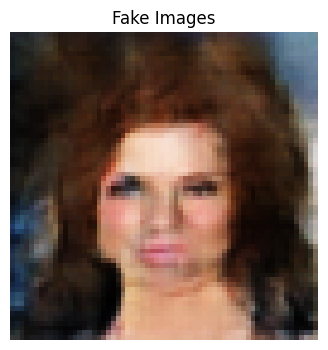

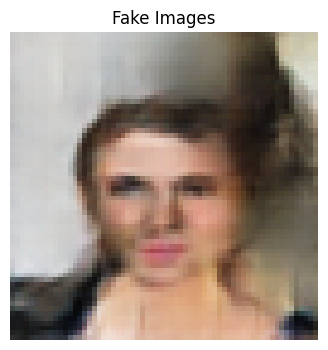

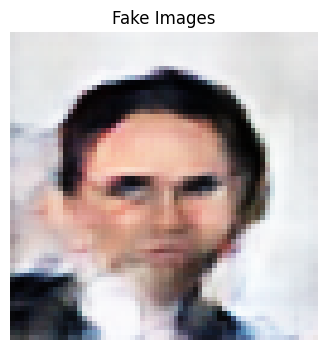

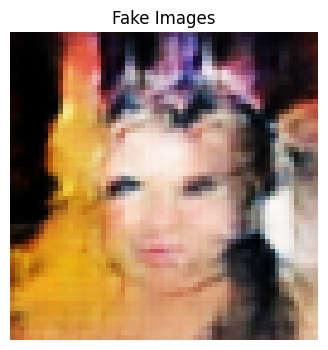

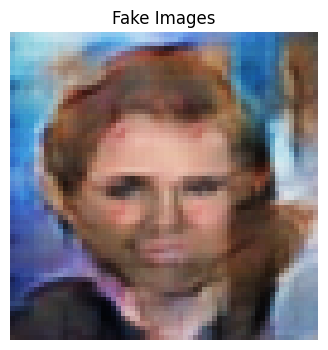

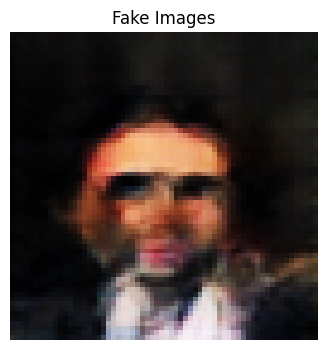

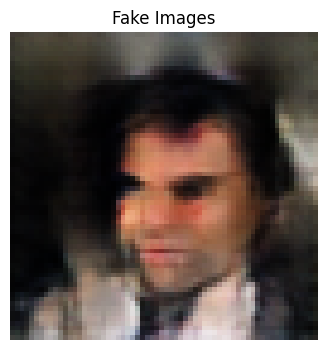

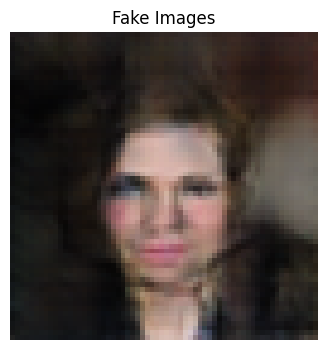

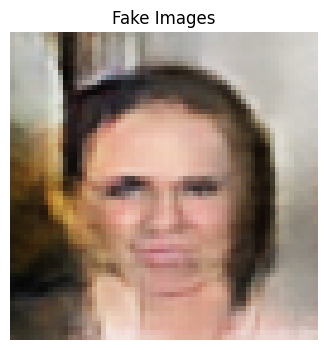

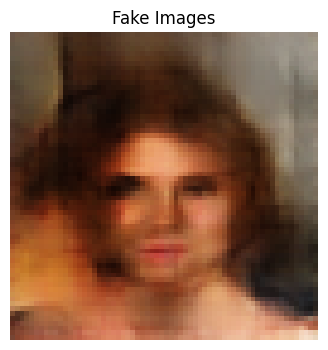

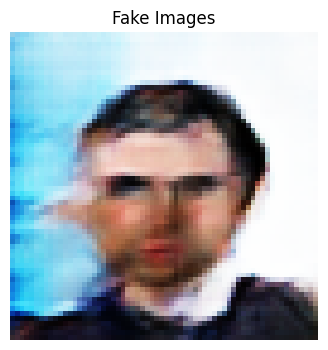

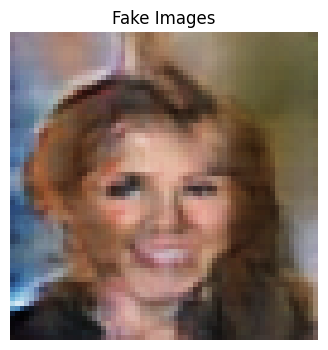

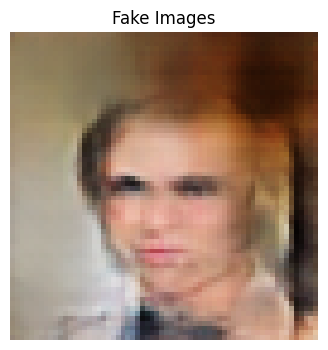

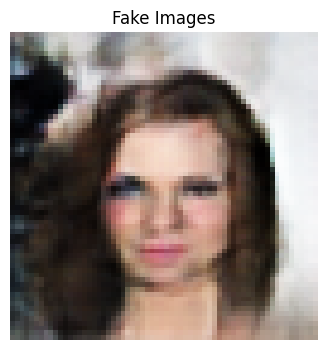

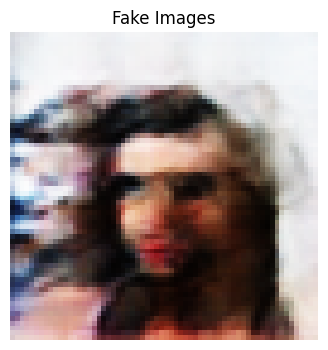

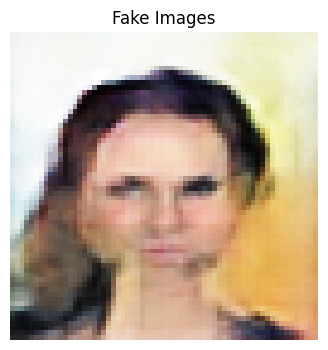

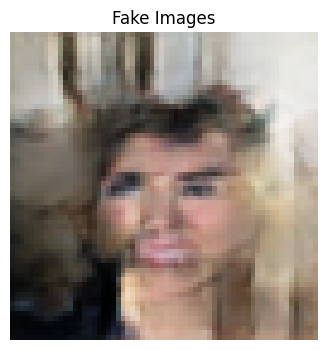

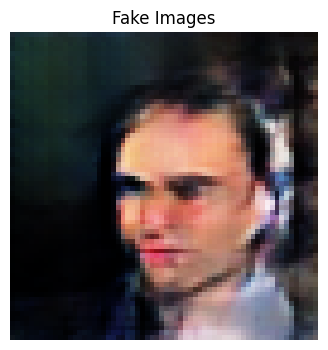

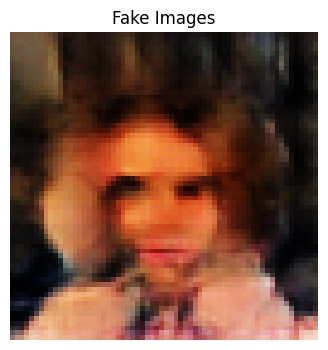

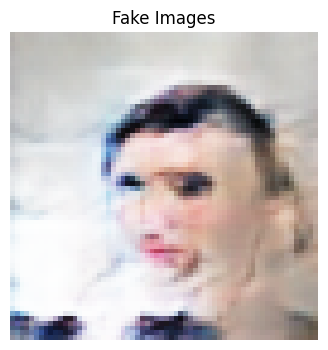

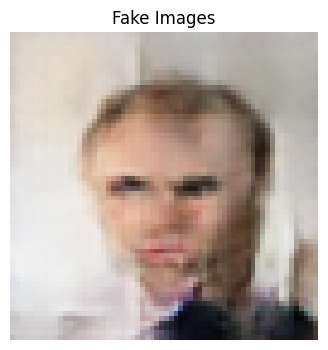

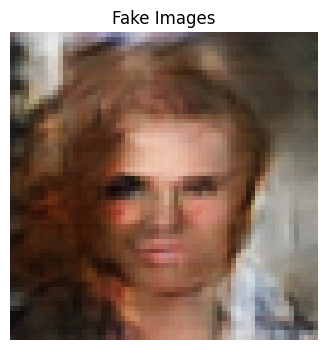

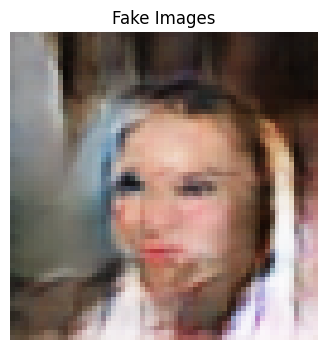

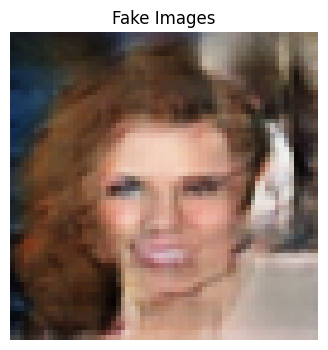

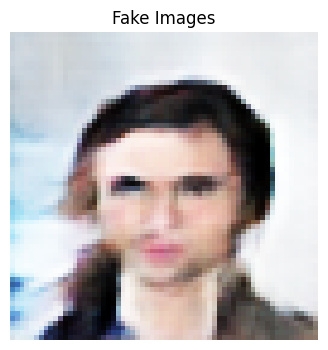

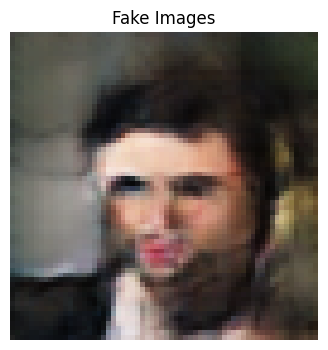

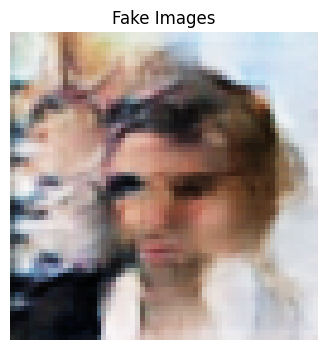

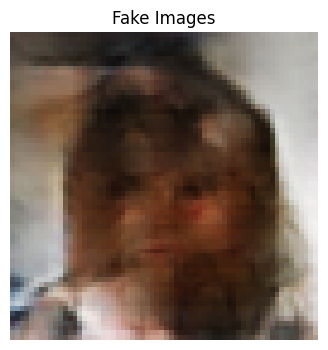

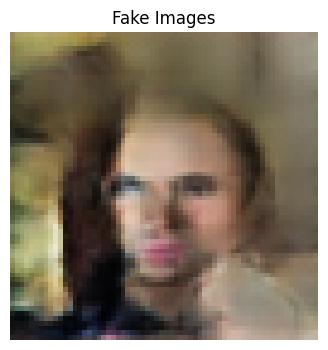

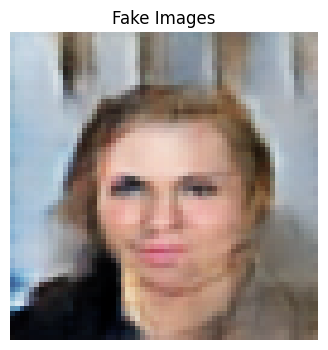

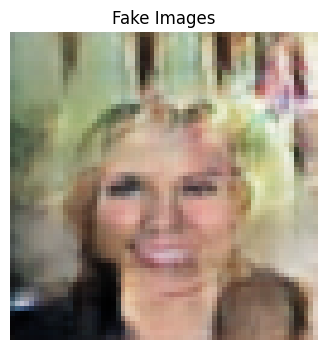

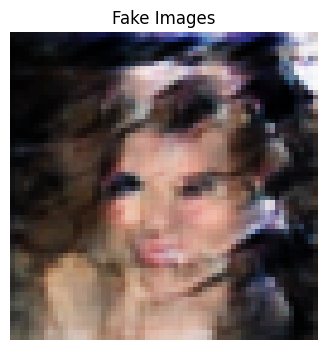

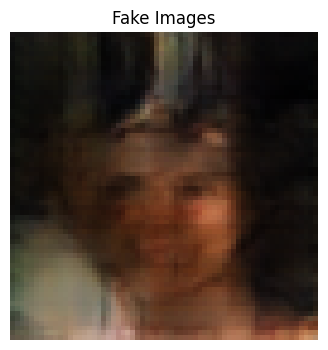

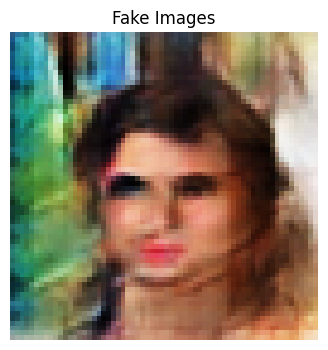

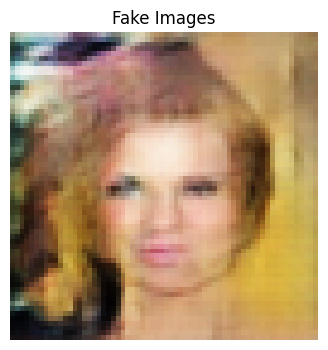

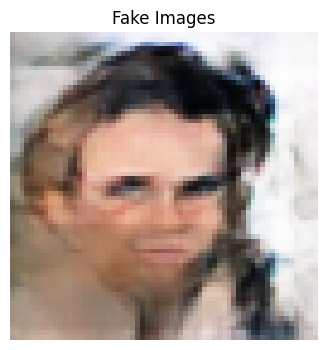

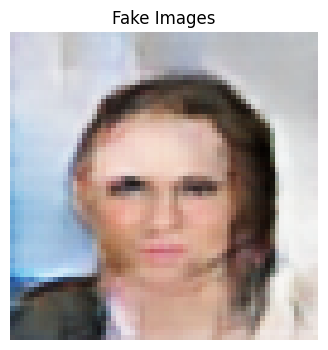

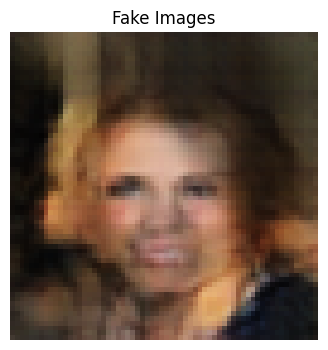

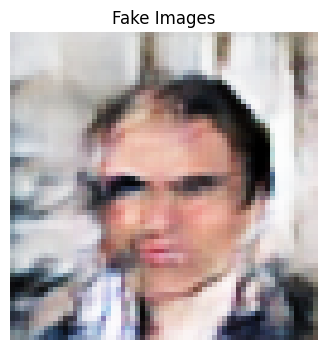

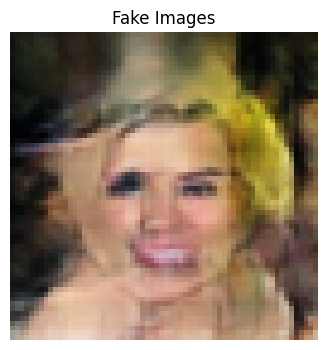

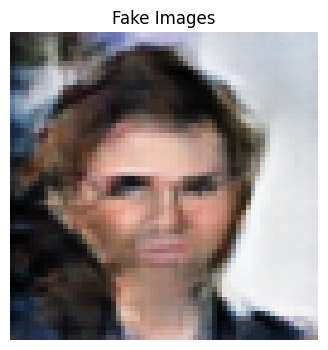

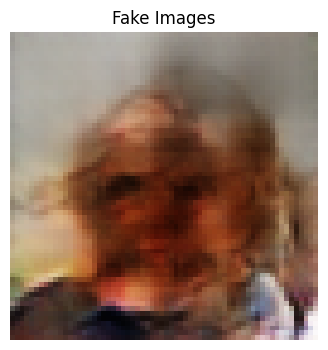

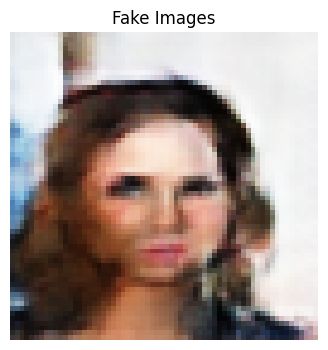

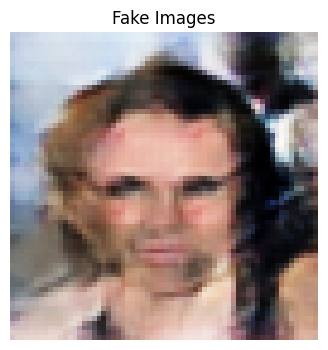

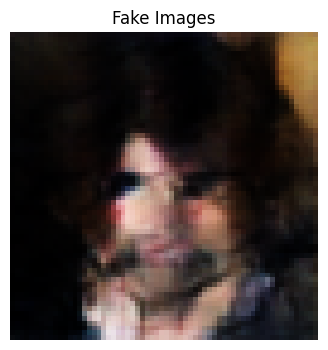

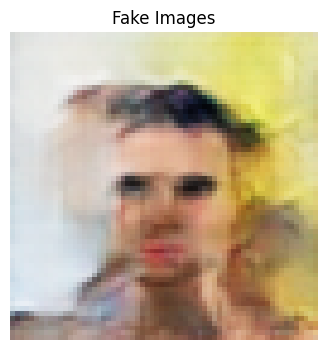

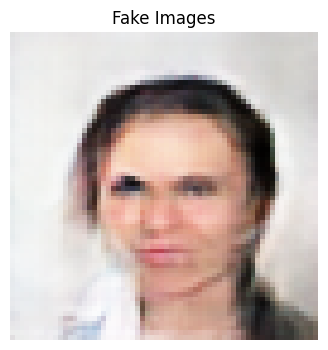

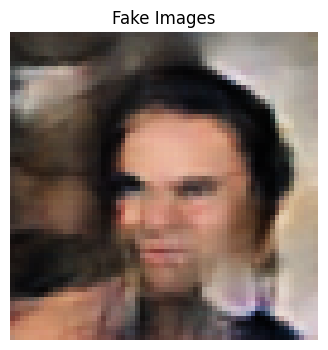

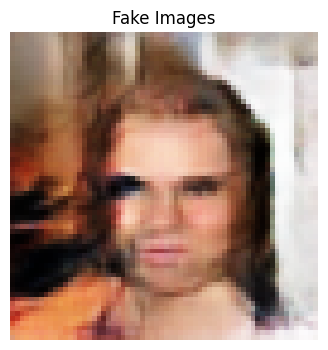

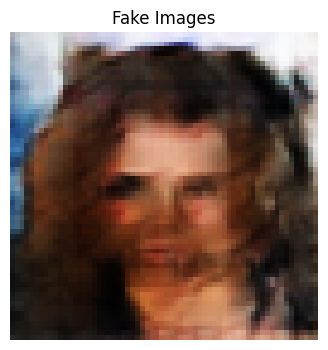

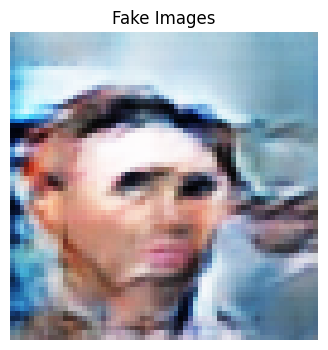

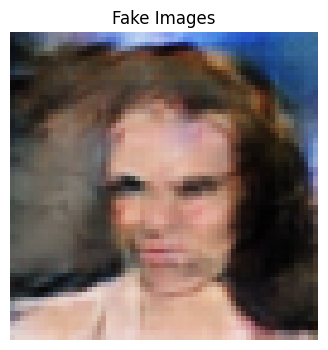

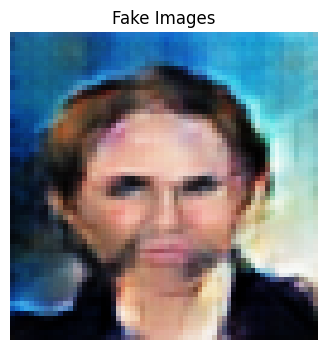

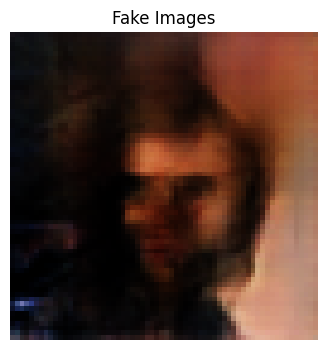

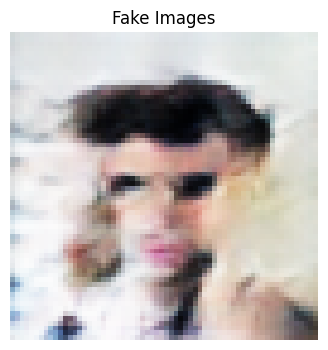

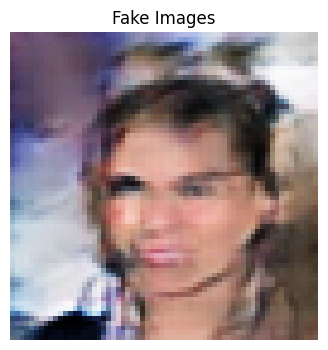

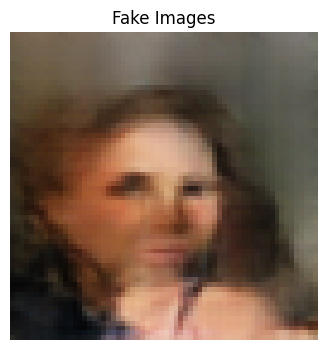

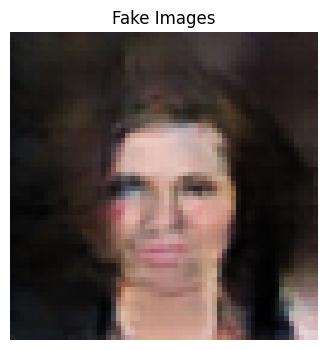

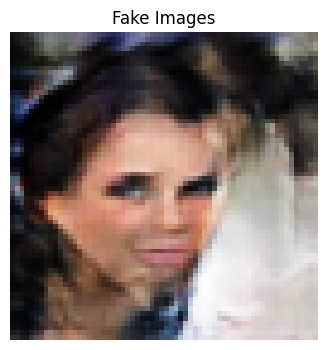

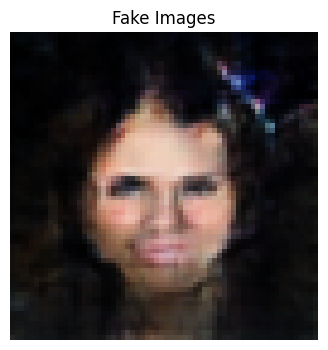

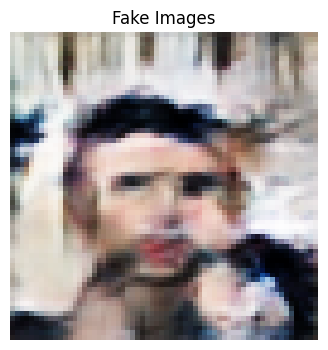

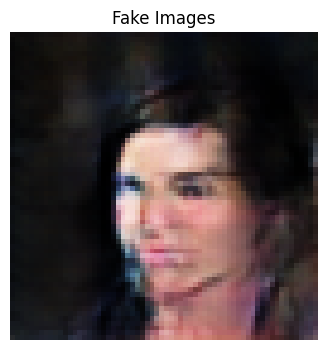

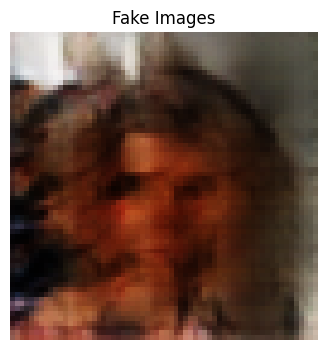

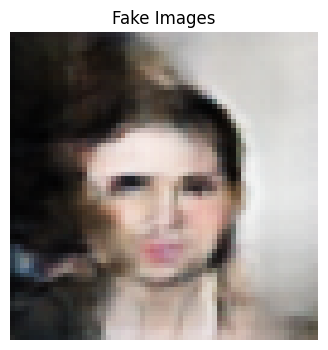

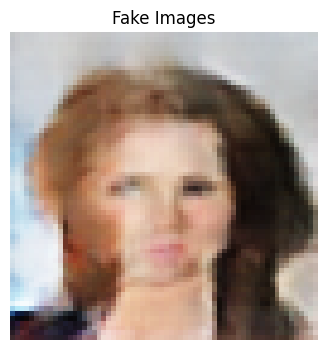

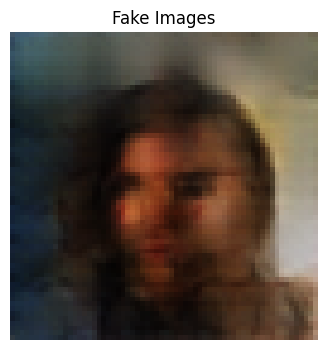

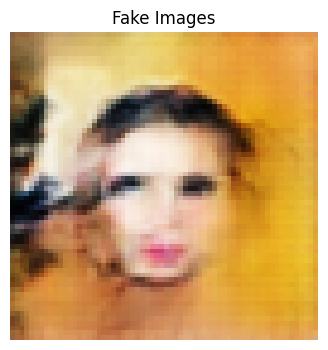

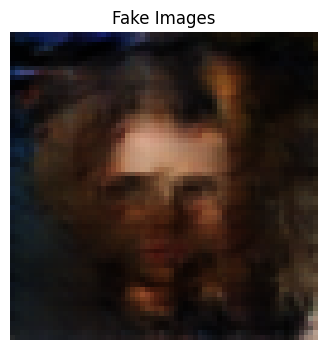

In [ ]:
for n in range (100):
  real_cpu_np = real_cpu.cpu().numpy().transpose(0, 2, 3, 1)
  fake_np = fake.detach().cpu().numpy().transpose(0, 2, 3, 1)

  # Shift and scale the images back to the range [0, 1]
  real_cpu_np = (real_cpu_np + 1) / 2.0
  fake_np = (fake_np + 1) / 2.0

  # Generate fake images
  fake = netG(fixed_noise)

  # Convert the tensor images to numpy arrays and transpose the dimensions
  fake_np = fake.detach().cpu().numpy().transpose(0, 2, 3, 1)

  # Shift and scale the images back to the range [0, 1]
  fake_np = (fake_np + 1) / 2.0

  # Display fake images
  plt.figure(figsize=(4,4))
  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(np.clip(fake_np[n], 0, 1))
  plt.show()